# PyTorch MNIST Classifier - Local Example

_**Train and export a PyTorch CNN classifier for (a subset of) the [MNIST DIGITS](https://en.wikipedia.org/wiki/MNIST_database) dataset: Performing all storage and computation locally on the notebook.**_

This notebook works well with the `Python 3 (PyTorch 1.13 Python 3.9 CPU Optimized)` kernel on SageMaker Studio, or `conda_pytorch_p38` on classic SageMaker Notebook Instances.

---

The [dataset](https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz) is hosted in the [Registry of Open Data on AWS](https://registry.opendata.aws/fast-ai-imageclas/) and contains PNG images organized in folders by which digit they represent.

>❓*Can you figure out how to re-create this notebook's workflow using SageMaker more effectively?*

## Contents

1. **[Notebook Setup](#Notebook-Setup)**
1. **[Prepare the Data](#Prepare-the-Data)**
1. **[Load the Data From File](#Load-the-Data-From-File)**
1. **[Pre-Process the Data for our CNN](#Pre-Process-the-Data-for-our-CNN)**
1. **[Build a Model](#Build-a-Model)**
1. **[Fit the Model](#Fit-the-Model)**
1. **[Save the Trained Model](#Save-the-Trained-Model)**
1. **[Explore Results](#Explore-Results)**

See the accompanying **Instructions** notebook for more guidance!


## Notebook Setup

As usual, we'll start by installing any extra required libraries and importing dependencies.

> ℹ️ **Troubleshooting install issues** if you run in to `ModuleNotFoundError` below, or the interactive widgets don't render for you:
>
> - Check you ran the below `!pip install` commands, and restarted the notebook kernel before running other code cells.
> - If a module looks like it was installed successfully but is missing from the notebook kernel environment, you may need to `%pip install` instead to install them in the right place.
> - You may need to restart your notebook kernel after installing pip libraries - Especially if you already `import`ed affected modules or are running on a SageMaker Notebook Instance instead of Studio.
> - Check you have the **`@jupyter-widgets/jupyterlab-manager`** and **`ipycanvas`** JupyterLab widgets installed (Use the puzzle piece icon "Extension Manager" sidebar tab, or click *Settings > Enable Extension Manager* if you don't see it). "Rebuild" JupyterLab if prompted, then save your work and refresh the page once the build is complete. In Studio, you may also need to open a system terminal and run `restart-jupyter-server`.
>
> In practice (and in this workshop's CloudFormation templates), JupyterLab extensions are typically installed via **lifecycle configuration scripts** for [Studio](https://aws.amazon.com/blogs/machine-learning/customize-amazon-sagemaker-studio-using-lifecycle-configurations/) or [Notebook Instances](https://docs.aws.amazon.com/sagemaker/latest/dg/notebook-lifecycle-config.html) - rather than manual installs by users.

In [1]:
# First install some libraries which might not be available across all kernels (e.g. in Studio):
!pip install "ipycanvas<0.13" "ipywidgets<8" matplotlib

> ⚠️ ***RESTART your notebook kernel*** before continuing! (Circular arrow button in the toolbar)

If you don't restart the kernel after the install, the interactive drawing widget might not work later.

In [2]:
%load_ext autoreload
%autoreload 2

# Python Built-Ins:
import glob
import os

# External Dependencies:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# Local Notebook Utils:
import util

%matplotlib inline

print(f"Using PyTorch version {torch.__version__}")

Using PyTorch version 2.1.0


## Prepare the Data

Now let's download the image data.

The original MNIST data has 70,000 small 28x28 pixel PNG files (60,000 in the training dataset, and 10,000 in the test dataset). This format is nice and familiar - but a large number of tiny files is inefficient for storage and transfer - so **to keep things performant** we will:

- Download the data to a local temporary folder under `/tmp` (meaning you won't see the files in the left sidebar in SageMaker)
- Sample just a subset of the data to work with.

In [3]:
local_dir = "/tmp/mnist"
training_dir = f"{local_dir}/training"
testing_dir = f"{local_dir}/testing"

# Download the MNIST data from the Registry of Open Data on AWS
!rm -rf {local_dir}
!mkdir -p {local_dir}
!aws s3 cp s3://fast-ai-imageclas/mnist_png.tgz {local_dir} --no-sign-request

# Un-tar the MNIST data, stripping the leading path element; this will leave us with directories
# {local_dir}/testing/ and {local_dir/training/
!tar zxf {local_dir}/mnist_png.tgz -C {local_dir}/ --strip-components=1 --no-same-owner

# Get the list of files in the training and testing directories recursively
train_files = sorted(list(glob.iglob(os.path.join(training_dir, "*/*.png"), recursive=True)))
test_files = sorted(list(glob.iglob(os.path.join(testing_dir, "*/*.png"), recursive=True)))

print(f"Training files: {len(train_files)}")
print(f"Testing files:  {len(test_files)}")

# Reduce the data by keeping every Nth file and dropping the rest of the files.
reduction_factor = 2
train_files_to_keep = train_files[::reduction_factor]
test_files_to_keep = test_files[::reduction_factor]

print(f"Training files kept: {len(train_files_to_keep)}")
print(f"Testing files kept:  {len(test_files_to_keep)}")

# Delete all the files not to be kept
for fname in set(train_files) ^ set(train_files_to_keep):
    os.remove(fname)

for fname in set(test_files) ^ set(test_files_to_keep):
    os.remove(fname)

print("Done!")

download: s3://fast-ai-imageclas/mnist_png.tgz to ../../../../../../tmp/mnist/mnist_png.tgz
Training files: 60000
Testing files:  10000
Training files kept: 30000
Testing files kept:  5000
Done!


## Load the Data From File

Now our images are stored in the `{local_dir}` folder, let's read our training and testing sets in from these files.

```
    {local_dir}
    |----------------.
    `-- testing      `-- training
        |-- 0       |-- 0
        |               `-- 1.png
        |-- 1       |-- 1
        |-- 2       |-- 2
        |-- 3       |-- 3
        |-- 4       |-- 4
        |-- 5       |-- 5
        |-- 6       |-- 6
        |-- 7       |-- 7
        |-- 8       |-- 8
        `-- 9       `-- 9
```

(For both training and testing) We'll loop through each folder taking the target label (`0`-`9`) from the folder name and loading each PNG into an image matrix.

In [4]:
from PIL import Image

labels = sorted(os.listdir(training_dir))
n_labels = len(labels)

x_train = []
y_train = []
x_test = []
y_test = []
print("Loading label ", end="")
for ix_label in range(n_labels):
    label_str = labels[ix_label]
    print(f"{label_str}...", end="")
    trainfiles = filter(
        lambda s: s.endswith(".png"),
        os.listdir(os.path.join(training_dir, label_str)),
    )
    for filename in trainfiles:
        with open(os.path.join(training_dir, label_str, filename), "rb") as imgfile:
            x_train.append(np.squeeze(np.asarray(Image.open(imgfile))))
            y_train.append(ix_label)
    # Repeat for test data:
    testfiles = filter(
        lambda s: s.endswith(".png"),
        os.listdir(os.path.join(testing_dir, label_str)),
    )
    for filename in testfiles:
        with open(os.path.join(testing_dir, label_str, filename), "rb") as imgfile:
            x_test.append(np.squeeze(np.asarray(Image.open(imgfile))))
            y_test.append(ix_label)
print()

print("Shuffling trainset...")
train_shuffled = [(x_train[ix], y_train[ix]) for ix in range(len(y_train))]
np.random.shuffle(train_shuffled)

x_train = np.array([datum[0] for datum in train_shuffled])
y_train = np.array([datum[1] for datum in train_shuffled])
train_shuffled = None

print("Shuffling testset...")
test_shuffled = [(x_test[ix], y_test[ix]) for ix in range(len(y_test))]
np.random.shuffle(test_shuffled)

x_test = np.array([datum[0] for datum in test_shuffled])
y_test = np.array([datum[1] for datum in test_shuffled])
test_shuffled = None

print("Done!")

Loading label 0...1...2...3...4...5...6...7...8...9...
Shuffling trainset...
Shuffling testset...
Done!


**Before we go ahead**, let's just quickly visualize the data distribution.

x_train.shape (30000, 28, 28); dtype uint8
y_train.shape (30000,); dtype int64
x_test.shape (5000, 28, 28); dtype uint8
y_test.shape (5000,); dtype int64


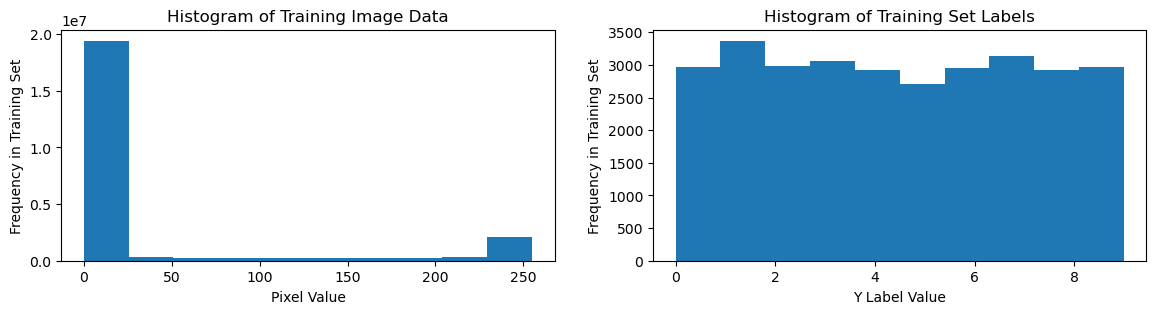

In [5]:
print(f"x_train.shape {x_train.shape}; dtype {x_train.dtype}")
print(f"y_train.shape {y_train.shape}; dtype {y_train.dtype}")
print(f"x_test.shape {x_test.shape}; dtype {x_test.dtype}")
print(f"y_test.shape {y_test.shape}; dtype {y_test.dtype}")

fig = plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 2, 1)
plt.hist(x_train.flatten())
ax.set_title("Histogram of Training Image Data")
ax.set_ylabel("Frequency in Training Set")
ax.set_xlabel("Pixel Value")

ax = plt.subplot(1, 2, 2)
plt.hist(y_train)
ax.set_title("Histogram of Training Set Labels")
ax.set_ylabel("Frequency in Training Set")
ax.set_xlabel("Y Label Value")

plt.show()

It looks like the data is pretty evenly distributed between labels 0-9, and our images are encoded by fixed-size 28x28 matrices from 0 to 255. Here we will just plot a few examples to get a feel for them:

Some example images:


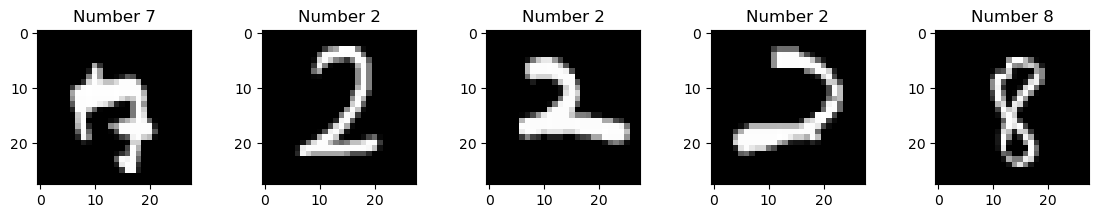

In [6]:
print("Some example images:")
fig = plt.figure(figsize=(14, 2))
for i in range(5):
    fig = plt.subplot(1, 5, i + 1)
    ax = plt.imshow(x_train[i], cmap="gray")
    fig.set_title(f"Number {y_train[i]}")
plt.show()

## Pre-Process the Data for our CNN

Next, we'll tweak this format for our neural network:

- Normalizing pixel values to improve the numerical conditioning
- One-hot encoding our labels to suit a softmax classifier output of probabilities for each digit
- Adding both a batch dimension (for processing multiple samples in parallel) and a channel dimension (e.g. as if this were a 3-channel RGB image, except single-channel for grayscale) - as well as the X and Y axes.


In [7]:
x_train = np.expand_dims(x_train, 1)
x_test = np.expand_dims(x_test, 1)

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

input_shape = x_train.shape[1:]

print("x_train shape:", x_train.shape)
print("input_shape:", input_shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


def to_categorical(y, num_classes):
    """1-hot encodes a tensor"""
    return np.eye(num_classes, dtype="float32")[y]


# convert class vectors to binary class matrices
y_train = to_categorical(y_train, n_labels)
y_test = to_categorical(y_test, n_labels)

print("n_labels:", n_labels)
print("y_train shape:", y_train.shape)

x_train shape: (30000, 1, 28, 28)
input_shape: (1, 28, 28)
30000 train samples
5000 test samples
n_labels: 10
y_train shape: (30000, 10)


## Build a Model

At its core, the model is a 2D convolutional network with a softmax output layer that'll yield a confidence score for every possible label (e.g. 10 options for digit = 0 to 9).


In [8]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.max_pool2d = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.flatten1 = nn.Flatten()
        self.fc1 = nn.Linear(9216, 128)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten1(self.dropout1(self.max_pool2d(x)))
        x = F.relu(self.fc1(x))
        x = self.fc2(self.dropout2(x))
        return F.softmax(x, dim=-1)

Define training and evaluation script here.

In [9]:
def test(model, testloader, device):
    loss_function = F.binary_cross_entropy
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(output, target, reduction="mean").item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            target_index = target.max(1, keepdim=True)[1]
            correct += pred.eq(target_index).sum().item()

    test_loss /= len(testloader.dataset)
    print("val_loss: {:.4f}".format(test_loss))
    print("val_acc: {:.4f}".format(correct / len(testloader.dataset)))


def train(trainloader, testloader, epochs, num_classes):
    model = Net(num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    loss_function = F.binary_cross_entropy

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for batch_idx, (x_train, y_train) in enumerate(trainloader):
            data, target = x_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print("epoch: {}".format(epoch))
        print("train_loss: {:.6f}".format(running_loss / (len(trainloader.dataset))))
        print("Evaluating model")
        test(model, testloader, device)
    return model

The custom Dataset class below is to allow data loading.

In [10]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        """Initialization"""
        self.labels = labels
        self.data = data

    def __len__(self):
        """Denotes the total number of samples"""
        return len(self.data)

    def __getitem__(self, index):
        # Load data and get label
        X = self.data[index]
        y = self.labels[index]
        return X, y

## Fit the Model

In [11]:
%%time
batch_size = 128
epochs = 6

trainloader = torch.utils.data.DataLoader(
    Dataset(x_train, y_train),
    batch_size=batch_size,
    shuffle=True,
)
testloader = torch.utils.data.DataLoader(
    Dataset(x_test, y_test),
    batch_size=1,
    shuffle=True,
)

model = train(trainloader, testloader, epochs=epochs, num_classes=10)

epoch: 1
train_loss: 0.000873
Evaluating model
val_loss: 0.0355
val_acc: 0.9380
epoch: 2
train_loss: 0.000344
Evaluating model
val_loss: 0.0218
val_acc: 0.9612
epoch: 3
train_loss: 0.000233
Evaluating model
val_loss: 0.0168
val_acc: 0.9710
epoch: 4
train_loss: 0.000174
Evaluating model
val_loss: 0.0119
val_acc: 0.9776
epoch: 5
train_loss: 0.000147
Evaluating model
val_loss: 0.0101
val_acc: 0.9812
epoch: 6
train_loss: 0.000128
Evaluating model
val_loss: 0.0095
val_acc: 0.9816
CPU times: user 34.8 s, sys: 851 ms, total: 35.6 s
Wall time: 35.6 s


## Save the Trained Model

Torch JIT model allows us to store the inference script along with the model weights.

In [12]:
path = "./data/model/model.pth"
# Ensure the subfolder exists:
os.makedirs(path.rpartition("/")[0], exist_ok=True)

x = torch.rand((1, 1, 28, 28), dtype=torch.float)
model = model.cpu()
model.eval()
m = torch.jit.trace(model, x)
torch.jit.save(m, path)

## Explore Results

To try out the model we can take a sample image from the test set, predict the label, and plot it:

Result confidences: tensor([[6.8854e-04, 2.5707e-08, 9.9931e-01, 3.6195e-06, 7.1614e-10, 2.9284e-11,
         3.5274e-11, 2.7079e-07, 7.7730e-08, 1.4994e-07]])


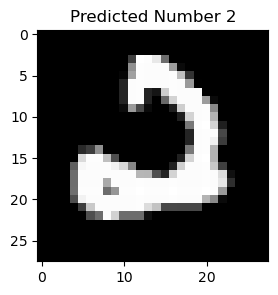

In [13]:
# Choose an image:
label = "2"
filename = os.listdir(f"{testing_dir}/{label}")[0]

# Load the image:
img = Image.open(f"{testing_dir}/{label}/{filename}")
input_data = np.squeeze(np.asarray(img)).astype(np.float32) / 255
input_data = torch.tensor(np.expand_dims(input_data, [0, 1]))  # Add batch & leading channel dim

# Send to the model:
with torch.no_grad():
    result = model(input_data)
print(f"Result confidences: {result}")

# Plot the result:
plt.figure(figsize=(3, 3))
fig = plt.subplot(1, 1, 1)
ax = plt.imshow(img, cmap="gray")
fig.set_title(f"Predicted Number {np.argmax(result[0])}")
plt.show()

...Or even better, draw your own digit using this interactive widget - then run the cell below to classify it!

In [14]:
# Create/reload the widget:
widget = util.draw.PixelDrawCanvas(pen_size=4)
widget.display()

In [19]:
# Classify the image currently drawn in the widget:
img = widget.data.mean(-1) / 255  # (Convert full-RGB 0-255 to grayscale 0-1)
print("img: ", np.shape(img))
print("img: \n", img)
input_data = torch.FloatTensor(np.expand_dims(img, [0, 1]))  # Add batch & leading channel dimension
print(np.shape(input_data))

img:  (28, 28)
img: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]

Result confidences: tensor([[0.0948, 0.1213, 0.0919, 0.0978, 0.1084, 0.1045, 0.0966, 0.1017, 0.0910,
         0.0919]])


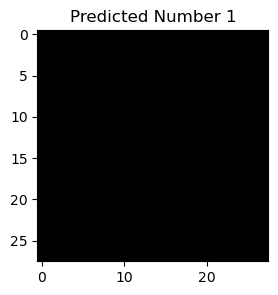

In [15]:


with torch.no_grad():
    result = model(input_data)
print(f"Result confidences: {result}")

# Plot the result:
plt.figure(figsize=(3, 3))
fig = plt.subplot(1, 1, 1)
ax = plt.imshow(img, cmap="gray")
fig.set_title(f"Predicted Number {np.argmax(result[0])}")
plt.show()

All done!
